### Importing Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize,StandardScaler,LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier

### Importing Dataset

In [39]:
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

In [40]:
test.shape

(418, 11)

In [41]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [42]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [44]:
train.shape

(891, 12)

In [45]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Cleaning Null Values

In [46]:
def clean(df):
    df['Age'].fillna(value=df['Age'].median(),inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0],inplace=True)
    df['Fare'].fillna(value=df['Fare'].median(),inplace=True)
    df.drop('Cabin',axis=1,inplace=True)
    # df.dropna(inplace=True)
    return df

In [47]:
train=clean(train)

In [48]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [49]:
train.shape

(891, 11)

### feature Encoding

In [50]:
enc=LabelEncoder()

def encod(df):
    df['Sex']=enc.fit_transform(df['Sex'])
    df=pd.get_dummies(columns=['Embarked'],data=df,dtype=int)
    df.drop(columns=["Embarked_C","Name","Ticket"],axis=1,inplace=True)
    df['Age']=df['Age'].astype(int)
    df['Fare']=round(df['Fare'],2)
    return df

In [51]:
train=encod(train)

### seperating the target variable

In [52]:
x=train.drop("Survived",axis=1)
y=train.iloc[:,1]

In [53]:
x.shape,y.shape

((891, 9), (891,))

### Feature importance / Feature Selection

In [54]:
feet=ExtraTreesClassifier()

In [55]:
feet.fit(x,y)

ExtraTreesClassifier()

<Axes: >

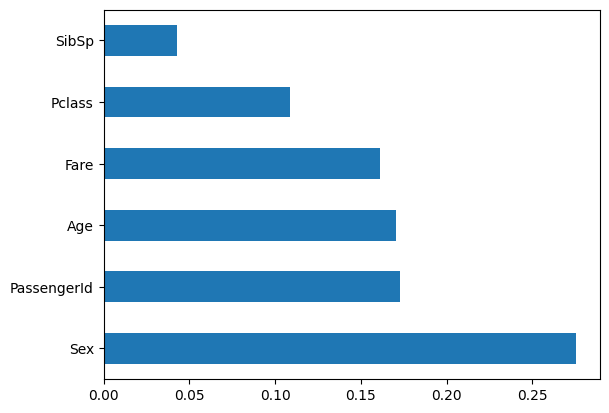

In [56]:
imp=pd.Series(feet.feature_importances_,index=x.columns)
imp.nlargest(6).plot(kind='barh')

In [57]:
# x=x[['SibSp','Pclass','Age','Fare','PassengerId','Sex']]
# y=train.iloc[:,0]

### Splitting data using Cross Validation

In [58]:
skf=StratifiedKFold(n_splits=5)

In [59]:
for train_index,test_index in skf.split(x,y):
    x_train,x_test=x.iloc[train_index],x.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]

In [60]:
x_train.shape,x_test.shape

((713, 9), (178, 9))

In [61]:
y_train.shape,y_test.shape

((713,), (178,))

### Choosing and Training the model

In [62]:
from sklearn.metrics import accuracy_score,classification_report

models={
    'LogisticRegression':LogisticRegression(),
    'DecisionTreeClassifer':DecisionTreeClassifier(),
    'RandomForestClassifer':RandomForestClassifier()
}

Accuracy={}
for i in models:
    model=models[i]
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    pred=pd.DataFrame({
        "actual_value":y_test,
        "predicted_value":y_pred
    })
    print(i)
    print(f'{pred.head()}')
    print("\nclassification_report")
    print(classification_report(y_test,y_pred))
    print(f'accurracy Score = {accuracy_score(y_test,y_pred)*100}')
    print("-----------------------------------------------------------")
    Accuracy[i]=accuracy_score(y_test,y_pred)*100

c:\Users\phing\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
     actual_value  predicted_value
706             1                1
707             1                0
708             1                1
709             1                0
710             1                1

classification_report
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       109
           1       0.81      0.70      0.75        69

    accuracy                           0.82       178
   macro avg       0.82      0.80      0.80       178
weighted avg       0.82      0.82      0.82       178

accurracy Score = 82.02247191011236
-----------------------------------------------------------
DecisionTreeClassifer
     actual_value  predicted_value
706             1                1
707             1                1
708             1                1
709             1                0
710             1                1

classification_report
              precision    recall  f1-score   support

           0   

In [63]:
Accuracy

{'LogisticRegression': 82.02247191011236,
 'DecisionTreeClassifer': 83.14606741573034,
 'RandomForestClassifer': 83.14606741573034}

- RandomForest has Maximum Accuracy 

In [64]:
model=RandomForestClassifier()

In [65]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [66]:
x_train.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [67]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [68]:
test=clean(test)
test=encod(test)

In [69]:
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [70]:
model=RandomForestClassifier()

In [71]:
model.fit(x,y)

RandomForestClassifier()

In [72]:
y_pred=model.predict(test)

In [73]:
pred=pd.DataFrame({
    "PassengerId":test['PassengerId'],
    'Survived':y_pred
})

In [74]:
pred

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [75]:
pred.shape

(418, 2)

In [76]:
pred.to_csv('Submision.csv')